In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2

In [744]:
page_x_inches: float = 11. # inches
page_y_inches: float = 14 # inches
border:float = 20.

buffer_style = 2

In [715]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds


In [716]:
planet = Point(140,-150).buffer(250, resolution=80)
planet_in_frame = planet.intersection(drawbox)

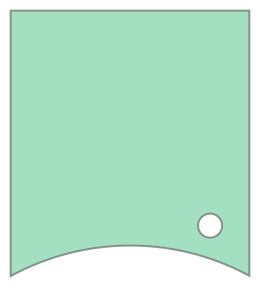

In [746]:
moon = Point(220, 120).buffer(12)

space = drawbox.difference(planet).difference(moon)

space

In [718]:
# poly = space

# pts = gp.get_random_points_in_polygon(poly, n_points=600)

In [719]:

# circle_to_fill = space
# # init
# fc_rad = gp.get_rad(circle_to_fill)
# x = circle_to_fill.centroid.x
# rads = np.random.uniform(4, 5, 20)
# circles = gp.circle_pack_within_poly(circle_to_fill, rads, progress_bar=True, max_additions=5)

In [747]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(space, xstep=2, ystep=2, flatmesh=True)

pts = [Point((x,y) + np.random.randn(2)*1) for x,y in zip(xs, ys)]

In [748]:
circles = MultiPolygon([p.buffer(1.2) for p in pts])

In [749]:
stars = []
for c in circles:
    d = c.distance(planet)
    buffer_distance = np.interp(d, [0, 100], [-1.3, -0.8]) + np.random.randn()* 0.1
    bc = c.buffer(buffer_distance)
    stars.append(bc)
    
stars = MultiPolygon(stars)

In [750]:
negative_space = gp.robust_difference(space, stars)

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 18.450900246595914 256.0237078162495 at 18.450900246595914 256.0237078162495


In [751]:
fill_curve = planet.boundary.intersection(space)
fill_curve = so.linemerge(fill_curve)

In [752]:
max_height = drawbox.bounds[3]

In [778]:
space_delta_yoff_start = 1.2
space_delta_yoff_end = 0.6
atmo_yoff_start = 2.

In [779]:
atmo_delta_yoffs = np.linspace(atmo_yoff_start, space_delta_yoff_start, 9)

In [780]:
yoff_deltas = list(atmo_delta_yoffs) + list(np.linspace(space_delta_yoff_start, space_delta_yoff_end,140)) + [space_delta_yoff_end] * 300

In [781]:
yoffs = np.cumsum(yoff_deltas)

In [782]:
fills = []
for i, yoff in enumerate(yoffs):
    y_shift_curve = sa.translate(fill_curve, yoff=yoff)
    if y_shift_curve.bounds[1] > max_height:
        break
        
    y_shift_curve = y_shift_curve.intersection(negative_space)
    
    if y_shift_curve.type == 'MultiLineString':
        y_shift_curves = list(y_shift_curve)
    else:
        y_shift_curves = [y_shift_curve]
        
    
    if (i % 2) == 0:
        x_order = np.argsort([-ysc.centroid.x for ysc in y_shift_curves])
        y_shift_curves = [y_shift_curves[i] for i in x_order]
        y_shift_curves = [LineString(np.flipud(np.array(ysc))) for ysc in y_shift_curves]
    fills+= y_shift_curves
    
    


In [783]:
positive_space = gp.merge_LineStrings(fills)

In [784]:
positive_space = sa.rotate(positive_space, 180)

In [785]:
sk = vsketch.Vsketch()
sk.size(page_format)

sk.scale('1mm')
# sk.stroke(1)
# sk.geometry(stars)
# sk.stroke(2)
# sk.geometry(planet_in_frame)
# sk.stroke(3)
# sk.geometry(moon)
sk.geometry(positive_space)
sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-17T19:58:46.053351 
 
 
 
 
 
 <polyline points="79.6551,1170.8377 85.5164,1167.6304 101.9633,1159.0459 118.5755,1150.786 135.3467,1142.8538 152.2704,1135.2524 169.34,1127.9848 186.5491,1121.0537 203.8909,1114.4618 221.3589,1108.2117 238.9461,1102.3057 256.6459,1096.7462 274.4515,1091.5353 292.356,1086.675 310.3524,1082.1671 328.4338,1078.0134 346.5934,1074.2156 364.824,1070.775 383.1186,1067.693 401.4702,1064.9708 419.8717,1062.6094 438.3161,1060.6098 456.7961,1058.9727 475.3047,1057.6987 493.8348,1056.7884 512.3792,1056.2421 530.9307,1056.0599 549.4822,1056.2421 568.0266,1056.7884 586.5566,1057.6987 605.0653,1058.9727 623.5453,1060.6098 641.9896,1062.6094 660.3912,1064.9708 678.7428,1067.693 697.0374,1070.775 715.268,1074.2156 733.4275,1078.0134 751.509,1082.1671 769.5054,1086.675 787.4098,1091.5353 805.2154,1096.7462 822.9152,1102.3057 840.5025,1108.2117 857.9704,1114.4618 875.3123,1121.0537 892.5213,1127.9848 909.591,1135.2524 926.5147,1142.8538 943.2859,1150.786 959.8981,1159.0459 976.3449,1167.6304"/>
 <polyline points="976.3449,1160.4493 959.8981,1151.8648 943.2859,1143.6049 926.5147,1135.6727 909.591,1128.0713 892.5213,1120.8037 875.3123,1113.8726 857.9704,1107.2807 840.5025,1101.0306 822.9152,1095.1246 805.2154,1089.5651 787.4098,1084.3542 769.5054,1079.4939 751.509,1074.986 733.4275,1070.8323 715.268,1067.0345 697.0374,1063.5939 678.7428,1060.5119 660.3912,1057.7897 641.9896,1055.4283 623.5453,1053.4287 605.0653,1051.7916 586.5566,1050.5176 568.0266,1049.6073 549.4822,1049.061 530.9307,1048.8788 512.3792,1049.061 493.8348,1049.6073 475.3047,1050.5176 456.7961,1051.7916 438.3161,1053.4287 419.8717,1055.4283 401.4702,1057.7897 383.1186,1060.5119 364.824,1063.5939 346.5934,1067.0345 328.4338,1070.8323 310.3524,1074.986 292.356,1079.4939 274.4515,1084.3542 256.6459,1089.5651 238.9461,1095.1246 221.3589,1101.0306 203.8909,1107.2807 186.5491,1113.8726 169.34,1120.8037 152.2704,1128.0713 135.3467,1135.6727 118.5755,1143.6049 101.9633,1151.8648 85.5164,1160.4493 79.6551,1163.6566"/>
 
 
 <polyline points="261.2218,1081.4228 274.4515,1077.551 292.356,1072.6907 310.3524,1068.1828 328.4338,1064.0292 346.5934,1060.2313 364.824,1056.7907 383.1186,1053.7087 401.4702,1050.9865 419.8717,1048.6252 438.3161,1046.6255 456.7961,1044.9884 475.3047,1043.7145 493.8348,1042.8041 512.3792,1042.2578 530.9307,1042.0757 549.4822,1042.2578 568.0266,1042.8041 586.5566,1043.7145 605.0653,1044.9884 623.5453,1046.6255 641.9896,1048.6252 660.3912,1050.9865 678.7428,1053.7087 697.0374,1056.7907 715.268,1060.2313 733.4275,1064.0292 751.509,1068.1828 769.5054,1072.6907 787.4098,1077.551 805.2154,1082.762 822.9152,1088.3215 840.5025,1094.2274 857.9704,1100.4776 875.3123,1107.0694 892.5213,1114.0005 909.591,1121.2682 924.1743,1127.8183"/>
 
 
 <polyline points="666.2002,1045.423 660.3912,1044.5613 641.9896,1042.2 623.5453,1040.2003 605.0653,1038.5632 586.5566,1037.2893 568.0266,1036.3789 549.4822,1035.8326 530.9307,1035.6505 512.3792,1035.8326 493.8348,1036.3789 475.3047,1037.2893 456.7961,1038.5632 438.3161,1040.2003 419.8717,1042.2 401.4702,1044.5613 383.1186,1047.2835 364.824,1050.3655 346.5934,1053.8061 328.4338,1057.604 310.3524,1061.7576 292.356,1066.2655 274.4515,1071.1258 256.6459,1076.3368 238.9461,1081.8963 221.3589,1087.8022 203.8909,1094.0524 186.5491,1100.6442 169.34,1107.5753 152.2704,1114.843 135.3467,1122.4443 118.5755,1130.3765 101.9633,1138.6364 85.5164,1147.2209 79.6551,1150.4283"/>
 
 
 
 
 
 
 <polyline points="732.2061,1045.632 715.268,1042.0896 697.0374,1038.649 678.7428,1035.567 660.3912,1032.8448 641.9896,1030.4834 623.5453,1028.4838 605.0653,1026.8467 586.5566,1025.5727 568.0266,1024.6624 549.4822,1024.1161 530.9307,1023.9339 512.3792,1024.1161 493.8348,1024.6624 475.3047,1025.5727 456.7961,1026.8467 438.3161,1028.4838 419.8717,1030.4834 401.4702,1032.8448 383.1186,1035.567 364.824,1038.649 346.5934,1042.0896 328.4338,1045.8874 310.3524,1050.0411 292.356,1

In [786]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/225_space_is_good.svg'
sk.vpype('linemerge --tolerance 0.1 -f')
sk.save(savepath)

# a little more license

In [787]:
page_x_inches: float = 11. # inches
page_y_inches: float = 17 # inches
border:float = 20.

buffer_style = 2

In [788]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds


In [789]:
planet = Point(140,-150).buffer(250, resolution=80)
planet_in_frame = planet.intersection(drawbox)

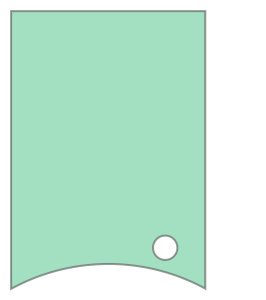

In [802]:
moon = Point(210, 120).buffer(15)

space = drawbox.difference(planet).difference(moon)

space

In [803]:
# poly = space

# pts = gp.get_random_points_in_polygon(poly, n_points=600)

In [804]:

# circle_to_fill = space
# # init
# fc_rad = gp.get_rad(circle_to_fill)
# x = circle_to_fill.centroid.x
# rads = np.random.uniform(4, 5, 20)
# circles = gp.circle_pack_within_poly(circle_to_fill, rads, progress_bar=True, max_additions=5)

In [821]:
(xbins, ybins), (xs, ys) = gp.overlay_grid(space, xstep=3., ystep=3., flatmesh=True)

pts = [Point((x,y) + np.random.randn(2)*2) for x,y in zip(xs, ys)]

In [835]:
circles = []
for p in pts:
    d = p.distance(planet)
    buffer_distance = np.interp(d, [0, 150], [-0.3, 2.5]) + np.interp(d, [350, 540], [0., 2.5])+ np.random.randn()* 0.3
    if d > 0:
        circles.append(p.buffer(buffer_distance))

In [836]:
stars = MultiPolygon(circles)

In [837]:
negative_space = gp.robust_difference(space, stars)

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 14.911036688999626 355.43145048260692 at 14.911036688999626 355.43145048260692


In [838]:
fill_curve = planet.boundary.intersection(space)
fill_curve = so.linemerge(fill_curve)

In [839]:
max_height = drawbox.bounds[3]

In [840]:
space_delta_yoff_start = 1.2
space_delta_yoff_end = 0.6
atmo_yoff_start = 2.5

In [841]:
atmo_delta_yoffs = np.linspace(atmo_yoff_start, space_delta_yoff_start, 8)

In [842]:
yoff_deltas = list(atmo_delta_yoffs) + list(np.linspace(space_delta_yoff_start, space_delta_yoff_end,140)) + [space_delta_yoff_end] * 300

In [843]:
yoffs = np.cumsum(yoff_deltas)

In [844]:
fills = []
for i, yoff in enumerate(yoffs):
    y_shift_curve = sa.translate(fill_curve, yoff=yoff)
    if y_shift_curve.bounds[1] > max_height:
        break
        
    y_shift_curve = y_shift_curve.intersection(negative_space)
    if y_shift_curve.length < 1e-3:
        break
        
    if y_shift_curve.type == 'MultiLineString':
        y_shift_curves = list(y_shift_curve)
    else:
        y_shift_curves = [y_shift_curve]
        
    
    if (i % 2) == 0:
        x_order = np.argsort([-ysc.centroid.x for ysc in y_shift_curves])
        y_shift_curves = [y_shift_curves[i] for i in x_order]
        y_shift_curves = [LineString(np.flipud(np.array(ysc))) for ysc in y_shift_curves]
    fills+= y_shift_curves
    
    


In [845]:
positive_space = gp.merge_LineStrings(fills)

In [846]:
positive_space = sa.rotate(positive_space, 180)

In [847]:
sk = vsketch.Vsketch()
sk.size(page_format)

sk.scale('1mm')
sk.geometry(positive_space)
sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-17T20:17:33.051673 
 
 
 
 
 
 
 <polyline points="183.3601,1409.3932 186.5491,1408.1088 203.8909,1401.5169 221.3589,1395.2668 238.9461,1389.3609 256.6459,1383.8013 274.4515,1378.5904 292.356,1373.7301 310.3524,1369.2222 328.4338,1365.0685 346.5934,1361.2707 364.824,1357.8301 383.1186,1354.7481 401.4702,1352.0259 419.8717,1349.6645 438.3161,1347.6649 456.7961,1346.0278 475.3047,1344.7538 493.8348,1343.8435 512.3792,1343.2972 530.9307,1343.115 549.4822,1343.2972 568.0266,1343.8435 586.5566,1344.7538 605.0653,1346.0278 623.5453,1347.6649 641.9896,1349.6645 660.3912,1352.0259 678.7428,1354.7481 697.0374,1357.8301 715.268,1361.2707 733.4275,1365.0685 751.509,1369.2222 769.5054,1373.7301 787.4098,1378.5904 805.2154,1383.8013 822.9152,1389.3609 840.5025,1395.2668 857.9704,1401.5169 875.3123,1408.1088 892.5213,1415.0399 909.591,1422.3075 926.5147,1429.9089 943.2859,1437.8411 959.8981,1446.101 976.3449,1454.6855"/>
 
 
 
 
 
 
 
 
 
 <polyline points="735.424,1341.3922 733.4275,1340.9336 715.268,1337.1357 697.0374,1333.6951 678.7428,1330.6131 660.3912,1327.8909 641.9896,1325.5295 623.5453,1323.5299 605.0653,1321.8928 586.5566,1320.6189 568.0266,1319.7085 549.4822,1319.1622 530.9307,1318.9801 512.3792,1319.1622 493.8348,1319.7085 475.3047,1320.6189 456.7961,1321.8928 438.3161,1323.5299 419.8717,1325.5295 401.4702,1327.8909 383.1186,1330.6131 364.824,1333.6951 346.5934,1337.1357 328.4338,1340.9336 310.3524,1345.0872 292.356,1349.5951 278.3599,1353.3945"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="303.2278,1319.9832 310.3524,1318.1986 328.4338,1314.0449 346.5934,1310.2471 364.824,1306.8065 383.1186,1303.7245 401.4702,1301.0023 419.8717,1298.6409 438.3161,1296.6413 456.7961,1295.0042 475.3047,1293.7302 493.8348,1292.8199 512.3792,1292.2736 530.9307,1292.0914 549.4822,1292.2736 568.0266,1292.8199 586.5566,1293.7302 605.0653,1295.0042 623.5453,1296.6413 641.9896,1298.6409 660.3912,1301.0023 678.7428,1303.7245 697.0374,1306.8065 715.268,1310.2471 733.4275,1314.0449 751.509,1318.1986 769.5054,1322.7065 787.4098,1327.5668 805.2154,1332.7777 822.9152,1338.3372 837.5108,1343.2386"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [713]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/222_space_is_good.svg'
sk.vpype('linemerge --tolerance 0.1 -f')
sk.save(savepath)